# Kex spiking experiment

> Can infrared spectroscopy detect Kex content?

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from lssm.loading import load_nir_kex_spike, load_mir_kex_spike

from lssm.preprocessing import (ContinuumRemoval, SpikeDiff, 
                                TakeDerivative, MeanCenter, MinScaler, BaselineALS)
from lssm.visualization import plot_spectra


from sklearn.decomposition import PCA, KernelPCA

sns.set_style("whitegrid")


import warnings
warnings.filterwarnings('ignore')


In [ ]:
pd.set_option('display.max_rows', 50)

## Utils

## Data loading & preprocessing

In [ ]:
smp_type = 'MIR'

if smp_type == 'MIR':
    ascending = False
    src_dir = Path().home() / 'pro/data/k-spiking/mir'
    X, wavenumbers, names = load_mir_kex_spike(src_dir)
    
else:
    ascending = True
    fname = Path().home() / 'pro/data/k-spiking/nir/2023-12-8 _FT-NIR-K-spiked soil.xlsx'
    X, wavenumbers, names = load_nir_kex_spike(fname)

print('X shape: ', X.shape)
print('First 10 wavenumbers: ', wavenumbers[:10])
print('First 5 names: ', names[:5])

X shape:  (58, 1738)
First 10 wavenumbers:  [649.8933 651.8218 653.7502 655.6787 657.6072 659.5356 661.4641 663.3926
 665.321  667.2495]
First 5 names:  ['LUI-0-0' 'LUI-0-1' 'LUI-0-2' 'LUI-0-3' 'LUI-0-4']


In [ ]:
names

array(['LUI-0-0', 'LUI-0-1', 'LUI-0-2', 'LUI-0-3', 'LUI-0-4', 'LUI-1-0',
       'LUI-1-1', 'LUI-1-2', 'LUI-1-3', 'LUI-1-4', 'LUI-2-0', 'LUI-2-1',
       'LUI-2-2', 'LUI-2-3', 'LUI-2-4', 'LUI-3-0', 'LUI-3-1', 'LUI-3-2',
       'LUI-3-3', 'LUI-3-4', 'SPA1-0-0', 'SPA1-0-2', 'SPA1-0-3',
       'SPA1-0-4', 'SPA1-1-0', 'SPA1-1-1', 'SPA1-1-2', 'SPA1-1-3',
       'SPA1-1-4', 'SPA1-2-0', 'SPA1-2-1', 'SPA1-2-2', 'SPA1-2-3',
       'SPA1-2-4', 'SPA1-3-0', 'SPA1-3-1', 'SPA1-3-2', 'SPA1-3-3',
       'SPA1-3-4', 'TM4.1-0-0', 'TM4.1-0-1', 'TM4.1-0-2', 'TM4.1-0-3',
       'TM4.1-0-4', 'TM4.1-0-5', 'TM4.1-1-0', 'TM4.1-1-1', 'TM4.1-1-2',
       'TM4.1-1-3', 'TM4.1-2-0', 'TM4.1-2-1', 'TM4.1-2-2', 'TM4.1-2-3',
       'TM4.1-3-0', 'TM4.1-3-1', 'TM4.1-3-2', 'TM4.1-3-3', 'TM4.1-3-4'],
      dtype='<U9')

In [ ]:
pipe = Pipeline([
    ('center', MeanCenter())])

# pipe = Pipeline([
#     ('derivative', TakeDerivative(window_length=91))
#     ])

X_t = pipe.fit_transform(X)

In [ ]:
def mean_replicates(X, names, substring): 
    return X[[substring in name for name in names],:].mean(axis=0)

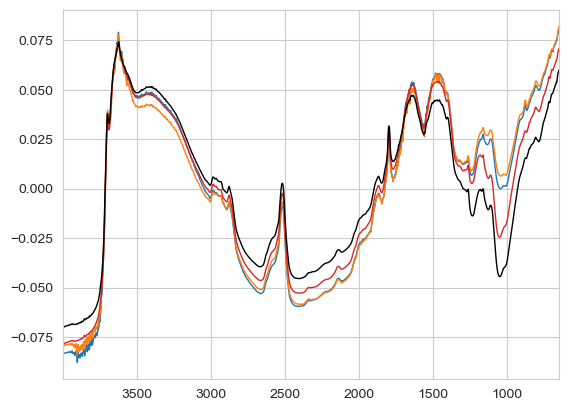

In [ ]:
# 'TM4.1', ‘SPA1', 'LUI'
substring  = 'SPA1'
X0, X1, X2, X3 = [mean_replicates(X_t, names, f'{substring}-{idx}') for idx in [0, 1, 2, 3]]

_min, _max = np.min(wavenumbers), np.max(wavenumbers)
plt.xlim(_max, _min)
sns.lineplot(x=wavenumbers, y=X0, lw=1, c='tab:blue')
sns.lineplot(x=wavenumbers, y=X1, lw=1, c='tab:orange')
sns.lineplot(x=wavenumbers, y=X2, lw=1, c='tab:red')
sns.lineplot(x=wavenumbers, y=X3, lw=1, c='black');

In [ ]:
def subset(x, start=800, end=1200, wavenumbers=wavenumbers):
    return x[(wavenumbers > start) & (wavenumbers < end)]
    
subset(X1)

array([0.05427971, 0.05444857, 0.05439833, 0.05410387, 0.05351989,
       0.05286643, 0.05228689, 0.05165435, 0.05113283, 0.05076343,
       0.05045037, 0.05018157, 0.04981379, 0.04944897, 0.04915357,
       0.04890217, 0.04866015, 0.04842433, 0.04810273, 0.04763035,
       0.04696267, 0.04644413, 0.04591873, 0.04545305, 0.04536849,
       0.04529425, 0.04448527, 0.04384045, 0.04332303, 0.04283743,
       0.04245731, 0.04221757, 0.04192393, 0.04165261, 0.04141981,
       0.04183209, 0.04278153, 0.04391799, 0.04458283, 0.04484347,
       0.04441233, 0.04362423, 0.04267609, 0.04188173, 0.04093631,
       0.04012221, 0.03943513, 0.03902107, 0.03859365, 0.03834243,
       0.03803421, 0.03788383, 0.03769641, 0.03766911, 0.03760699,
       0.03768101, 0.03758179, 0.03751923, 0.03717987, 0.03683409,
       0.03631847, 0.03582417, 0.03510471, 0.03449953, 0.03382055,
       0.03316417, 0.03238577, 0.03182613, 0.03107365, 0.03039967,
       0.02963747, 0.02894471, 0.02810869, 0.02742663, 0.02654

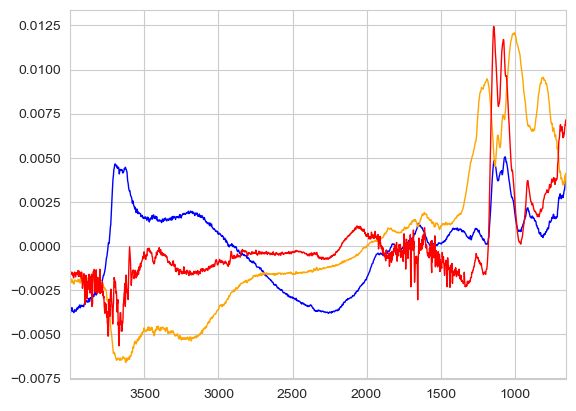

In [ ]:
# 'TM4.1', ‘SPA1', 'LUI'
substring  = 'LUI'
X0, X1, X2, X3 = [mean_replicates(X_t, names, f'{substring}-{idx}') for idx in [0, 1, 2, 3]]

_min, _max = np.min(wavenumbers), np.max(wavenumbers)
plt.xlim(_max, _min)
sns.lineplot(x=wavenumbers, y=X1-X0, lw=1, c='blue')
sns.lineplot(x=wavenumbers, y=X2-X0, lw=1, c='orange')
sns.lineplot(x=wavenumbers, y=X3-X0, lw=1, c='red');

In [ ]:
data = [subset(x, start=3000, end=3200) for x in [(X1 - X0), (X2 - X0), (X3 - X0)]]

# X_t_diff = np.c_[(X1 - X0), (X2 - X0), (X3 - X0)].transpose()
X_t_diff = np.c_[*data].transpose()

In [ ]:
n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_t_diff)

In [ ]:
pca.explained_variance_ratio_

array([9.99327615e-01, 6.72384693e-04])

In [ ]:
pca.components_

array([[-0.09686604, -0.09776158, -0.09902463, -0.09930993, -0.09713695,
        -0.09383666, -0.09253861, -0.09271834, -0.0929412 , -0.09462302,
        -0.09738852, -0.09933231, -0.09836697, -0.09970376, -0.10019198,
        -0.09760443, -0.09790116, -0.09768389, -0.09769966, -0.0988349 ,
        -0.0976634 , -0.09698766, -0.09722668, -0.09853708, -0.0982989 ,
        -0.09895609, -0.09919934, -0.0990656 , -0.09912793, -0.10097421,
        -0.10094513, -0.10070908, -0.09940538, -0.09877363, -0.09820729,
        -0.09895014, -0.10037855, -0.10039486, -0.09845148, -0.09633626,
        -0.09588209, -0.09755972, -0.09804509, -0.09841815, -0.0971526 ,
        -0.09758007, -0.0985124 , -0.09843799, -0.09808822, -0.09893809,
        -0.10017411, -0.09847545, -0.09924981, -0.10115088, -0.0995517 ,
        -0.09888162, -0.09876076, -0.0983931 , -0.09684787, -0.09535575,
        -0.09456199, -0.09521495, -0.09575038, -0.09691633, -0.09850292,
        -0.09820173, -0.09905781, -0.09753824, -0.0

In [ ]:
X_pca

array([[ 0.04535624, -0.00049667],
       [-0.00609584,  0.00126721],
       [-0.03926041, -0.00077054]])

<matplotlib.collections.PathCollection>

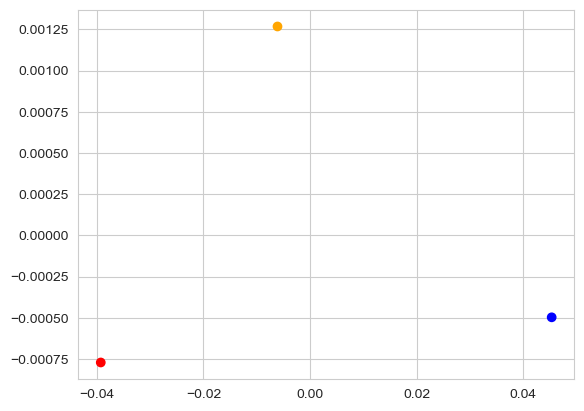

In [ ]:
c  = ['blue', 'orange', 'red']
plt.scatter(X_pca[:,0], X_pca[:, 1], c=c)

In [ ]:
cumsum = np.cumsum(pca.explained_variance_ratio_); cumsum

array([0.98082209, 1.        ])

<Figure size 640x480 with 0 Axes>

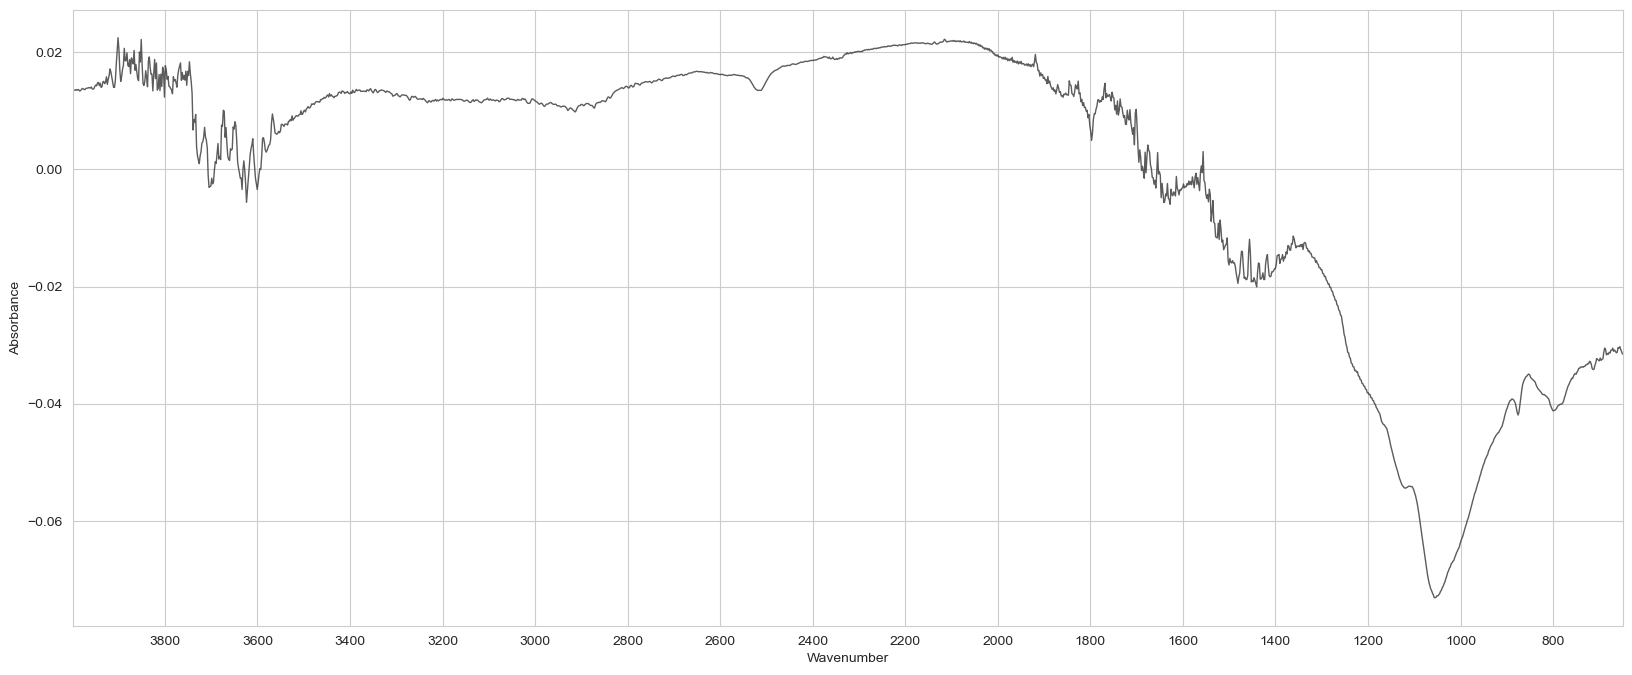

In [ ]:
plot_spectra(pca.components_[0], wavenumbers, figsize=(20, 8), ascending=ascending)

## Diff. of derivatives

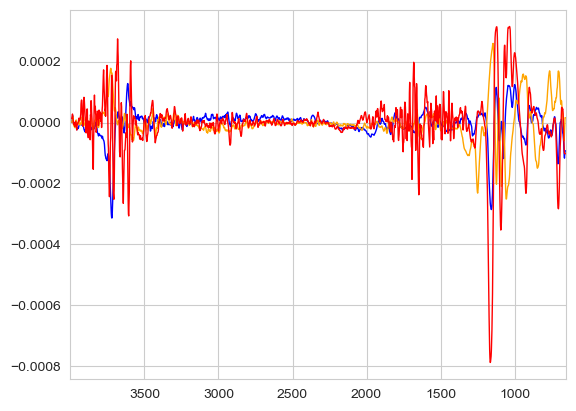

In [ ]:
# 'TM4.1', ‘SPA1', 'LUI'
substring  = 'LUI'
length = 11
polyorder=1
X0, X1, X2, X3 = [mean_replicates(X_t, names, f'{substring}-{idx}') for idx in [0, 1, 2, 3]]

_min, _max = np.min(wavenumbers), np.max(wavenumbers)
plt.xlim(_max, _min)
sns.lineplot(x=wavenumbers, y=TakeDerivative(window_length=length, polyorder=polyorder).fit_transform(X1-X0), lw=1, c='blue')
sns.lineplot(x=wavenumbers, y=TakeDerivative(window_length=length, polyorder=polyorder).fit_transform(X2-X0), lw=1, c='orange')
sns.lineplot(x=wavenumbers, y=TakeDerivative(window_length=length, polyorder=polyorder).fit_transform(X3-X0), lw=1, c='red');

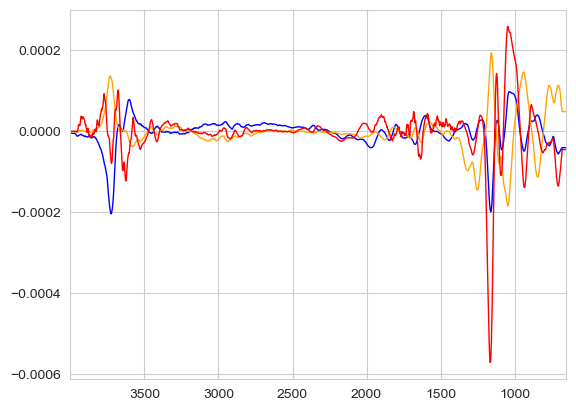

In [ ]:
# 'TM4.1', ‘SPA1', 'LUI'
substring  = 'LUI'
length = 31
X0, X1, X2, X3 = [mean_replicates(X_t, names, f'{substring}-{idx}') for idx in [0, 1, 2, 3]]

X0, X1, X2, X3 = [TakeDerivative(window_length=length).fit_transform(x) for x in [X0, X1, X2, X3]]

_min, _max = np.min(wavenumbers), np.max(wavenumbers)
plt.xlim(_max, _min)
sns.lineplot(x=wavenumbers, y=X1-X0, lw=1, c='blue')
sns.lineplot(x=wavenumbers, y=X2-X0, lw=1, c='orange')
sns.lineplot(x=wavenumbers, y=X3-X0, lw=1, c='red');

## PCA

In [ ]:
names

array(['LUI-0-0', 'LUI-0-1', 'LUI-0-2', 'LUI-0-3', 'LUI-0-4', 'LUI-1-0',
       'LUI-1-1', 'LUI-1-2', 'LUI-1-3', 'LUI-1-4', 'LUI-2-0', 'LUI-2-1',
       'LUI-2-2', 'LUI-2-3', 'LUI-2-4', 'LUI-3-0', 'LUI-3-1', 'LUI-3-2',
       'LUI-3-3', 'LUI-3-4', 'SPA1-0-0', 'SPA1-0-2', 'SPA1-0-3',
       'SPA1-0-4', 'SPA1-1-0', 'SPA1-1-1', 'SPA1-1-2', 'SPA1-1-3',
       'SPA1-1-4', 'SPA1-2-0', 'SPA1-2-1', 'SPA1-2-2', 'SPA1-2-3',
       'SPA1-2-4', 'SPA1-3-0', 'SPA1-3-1', 'SPA1-3-2', 'SPA1-3-3',
       'SPA1-3-4', 'TM4.1-0-0', 'TM4.1-0-1', 'TM4.1-0-2', 'TM4.1-0-3',
       'TM4.1-0-4', 'TM4.1-0-5', 'TM4.1-1-0', 'TM4.1-1-1', 'TM4.1-1-2',
       'TM4.1-1-3', 'TM4.1-2-0', 'TM4.1-2-1', 'TM4.1-2-2', 'TM4.1-2-3',
       'TM4.1-3-0', 'TM4.1-3-1', 'TM4.1-3-2', 'TM4.1-3-3', 'TM4.1-3-4'],
      dtype='<U9')

In [ ]:
# 'TM4.1', ‘SPA1', 'LUI'
smp = 'LUI'
mask_smp = np.char.find(names, smp) == 0
X_selected = X[mask_smp, :]
names_selected = names[mask_smp]
X_selected.shape

(20, 1738)

In [ ]:
# pipe = Pipeline([
#     ('cr', ContinuumRemoval(wavenumbers)),
#     ('diffs', SpikeDiff(names))])

# pipe = Pipeline([
#     ('cr', BaselineALS()),
#     ('diffs', SpikeDiff(names))])

# pipe = Pipeline([
#     ('cr', BaselineALS())])

# pipe = Pipeline([
#     ('center', MeanCenter())])

# pipe = Pipeline([
#     ('derivative', TakeDerivative(window_length=31)),
#     ('diffs', SpikeDiff(names))])

# pipe = Pipeline([
#     ('derivative', TakeDerivative(window_length=21))
#     ])

pipe = Pipeline([
    ('center', MeanCenter()),
    ('diffs', SpikeDiff(names_selected))])

X_t = pipe.fit_transform(X_selected)

In [ ]:
X_t.shape

(150, 1738)

In [ ]:
names_selected

array(['LUI-0-0', 'LUI-0-1', 'LUI-0-2', 'LUI-0-3', 'LUI-0-4', 'LUI-1-0',
       'LUI-1-1', 'LUI-1-2', 'LUI-1-3', 'LUI-1-4', 'LUI-2-0', 'LUI-2-1',
       'LUI-2-2', 'LUI-2-3', 'LUI-2-4', 'LUI-3-0', 'LUI-3-1', 'LUI-3-2',
       'LUI-3-3', 'LUI-3-4'], dtype='<U9')

In [ ]:
pipe[1].idx

array([[ 5,  0],
       [ 5,  1],
       [ 5,  2],
       [ 5,  3],
       [ 5,  4],
       [ 6,  0],
       [ 6,  1],
       [ 6,  2],
       [ 6,  3],
       [ 6,  4],
       [ 7,  0],
       [ 7,  1],
       [ 7,  2],
       [ 7,  3],
       [ 7,  4],
       [ 8,  0],
       [ 8,  1],
       [ 8,  2],
       [ 8,  3],
       [ 8,  4],
       [ 9,  0],
       [ 9,  1],
       [ 9,  2],
       [ 9,  3],
       [ 9,  4],
       [10,  0],
       [10,  1],
       [10,  2],
       [10,  3],
       [10,  4],
       [10,  5],
       [10,  6],
       [10,  7],
       [10,  8],
       [10,  9],
       [11,  0],
       [11,  1],
       [11,  2],
       [11,  3],
       [11,  4],
       [11,  5],
       [11,  6],
       [11,  7],
       [11,  8],
       [11,  9],
       [12,  0],
       [12,  1],
       [12,  2],
       [12,  3],
       [12,  4],
       [12,  5],
       [12,  6],
       [12,  7],
       [12,  8],
       [12,  9],
       [13,  0],
       [13,  1],
       [13,  2],
       [13,  3

<Figure size 640x480 with 0 Axes>

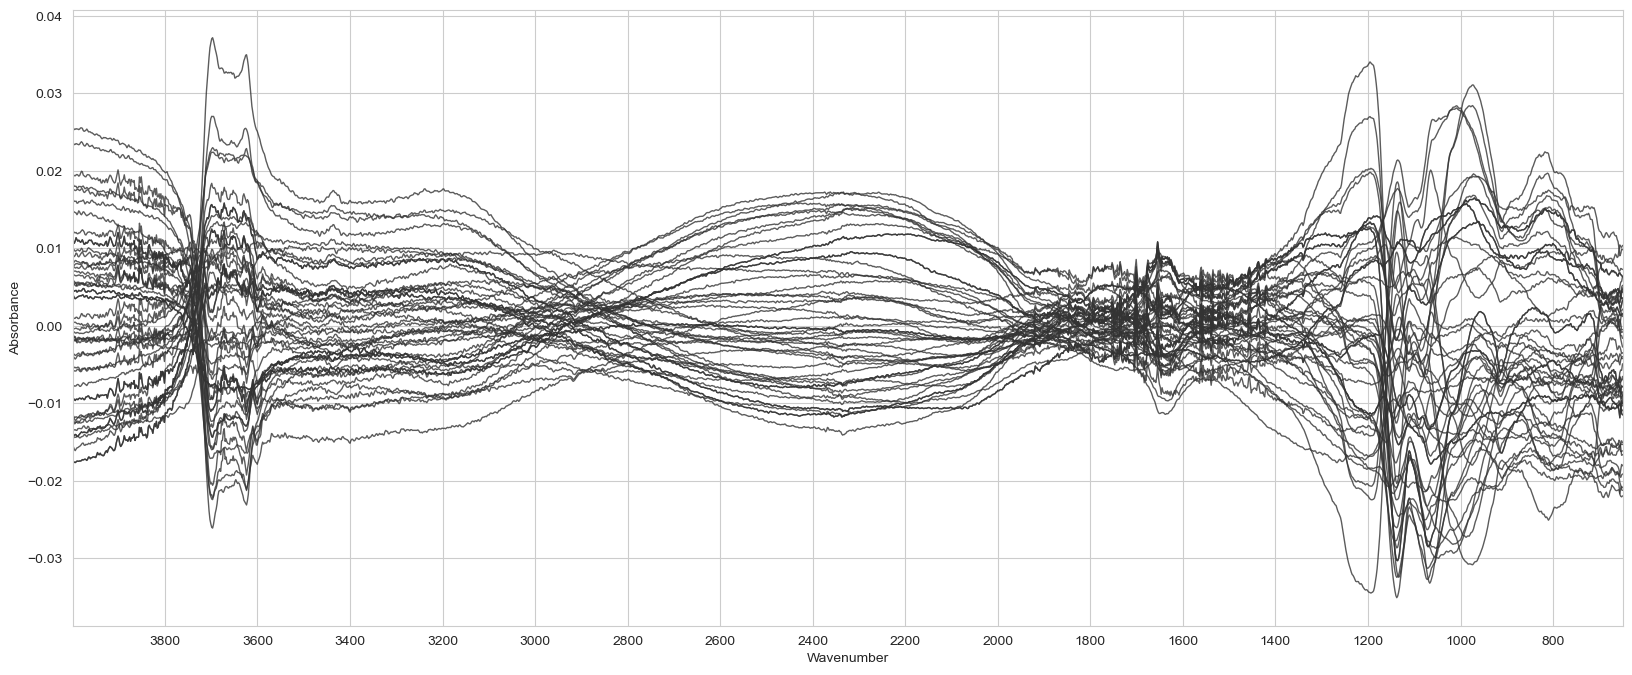

In [ ]:
plot_spectra(X_t, wavenumbers, figsize=(20, 8), ascending=ascending)

<Figure size 640x480 with 0 Axes>

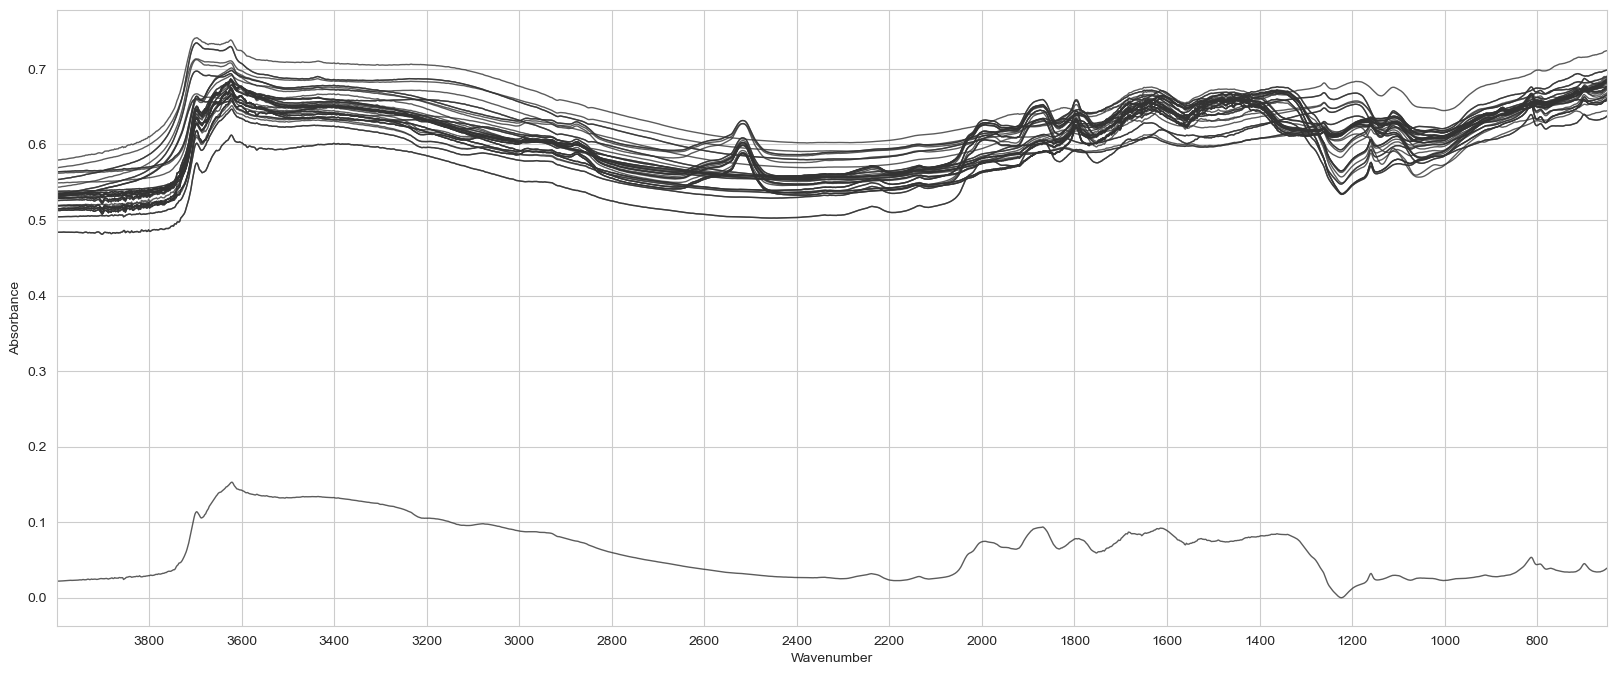

In [ ]:
plot_spectra(X, wavenumbers, figsize=(20, 8), ascending=ascending)

<Figure size 640x480 with 0 Axes>

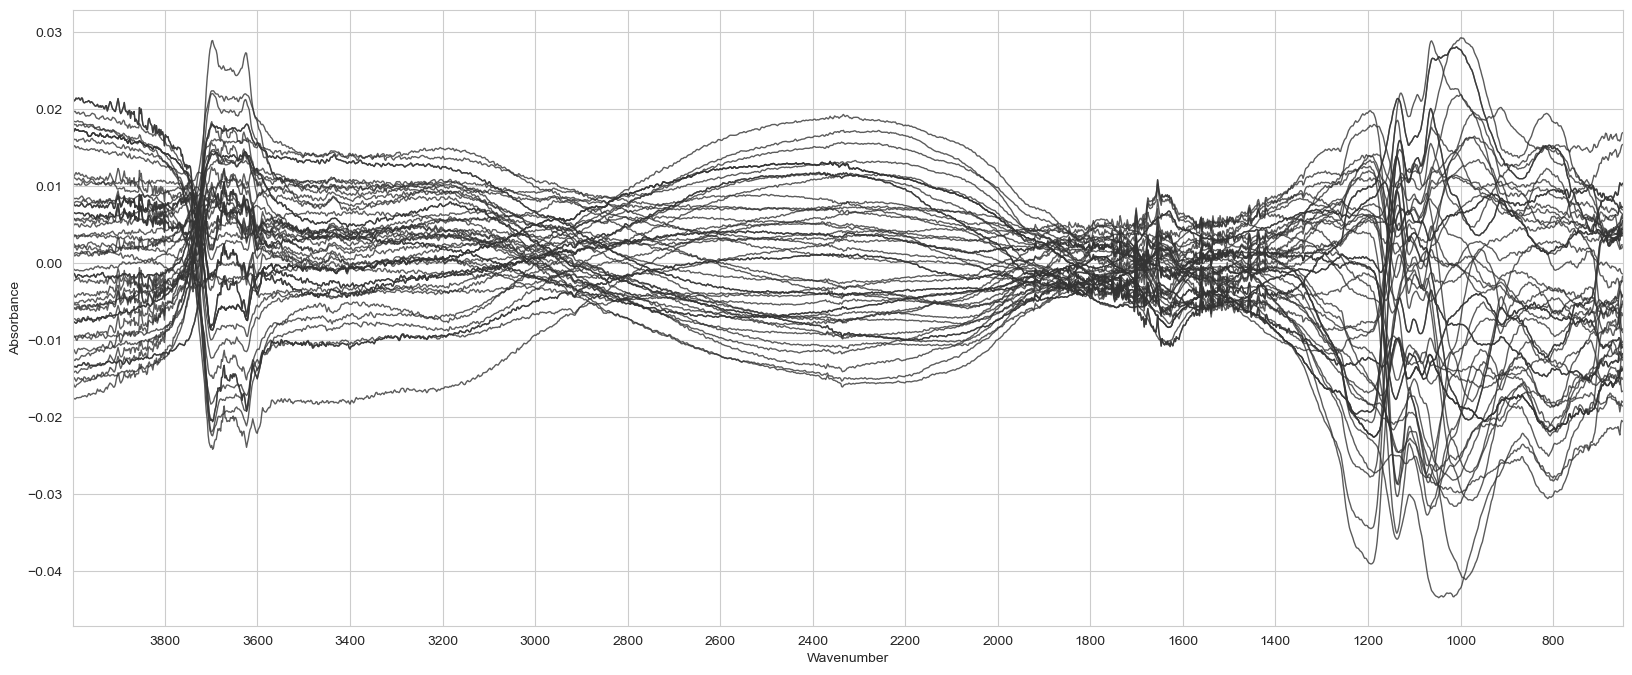

In [ ]:
plot_spectra(X_t, wavenumbers, figsize=(20, 8), ascending=ascending)

In [ ]:
n_components = 10
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_t)

In [ ]:
pca.explained_variance_ratio_

array([5.74220407e-01, 3.06284856e-01, 8.87014726e-02, 1.65167794e-02,
       6.59029798e-03, 3.99204427e-03, 1.30376598e-03, 1.14084508e-03,
       3.90145485e-04, 3.48482064e-04])

In [ ]:
cumsum = np.cumsum(pca.explained_variance_ratio_); cumsum

array([0.57422041, 0.88050526, 0.96920674, 0.98572351, 0.99231381,
       0.99630586, 0.99760962, 0.99875047, 0.99914061, 0.9994891 ])

In [ ]:
kaolinite = [1e7 / i for i in [1395, 1415, 2165, 2207]]; kaolinite

[7168.458781362007, 7067.137809187279, 4618.937644341801, 4531.037607612143]

In [ ]:
illite = [1e7 / i for i in [2207, 2345, 2450]]; illite

[4531.037607612143, 4264.392324093817, 4081.6326530612246]

In [ ]:
smectite = [1e7 / i for i in [1912, 2207, 2230]]; smectite

[5230.125523012553, 4531.037607612143, 4484.304932735426]

<Figure size 640x480 with 0 Axes>

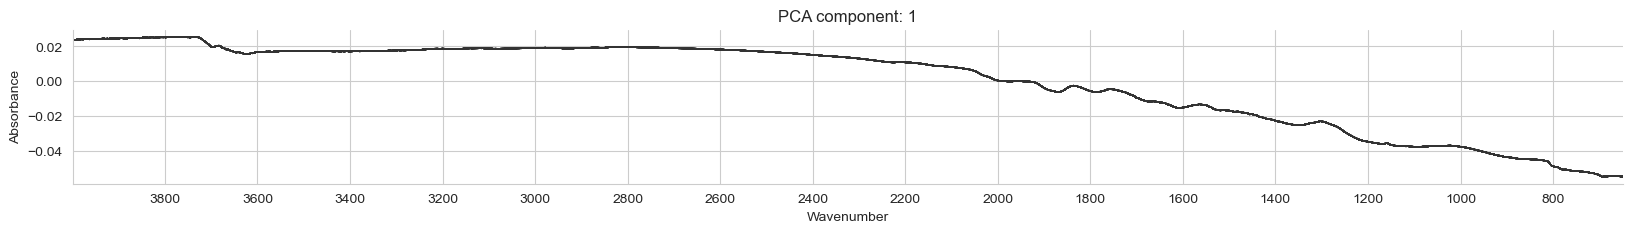

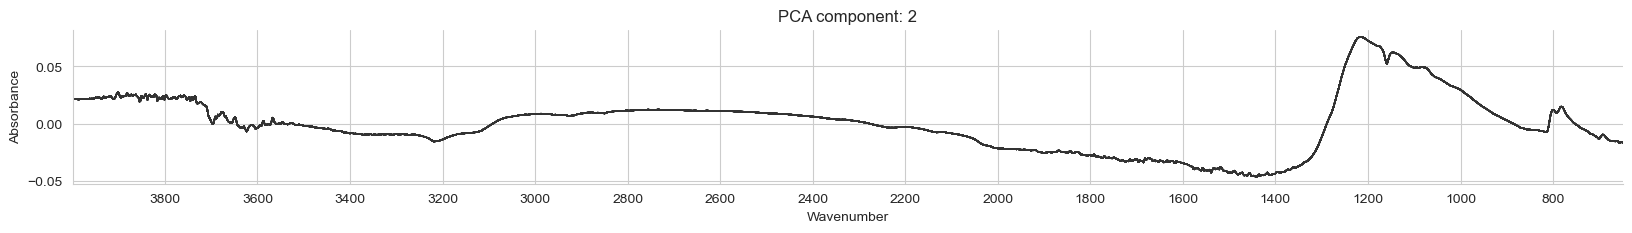

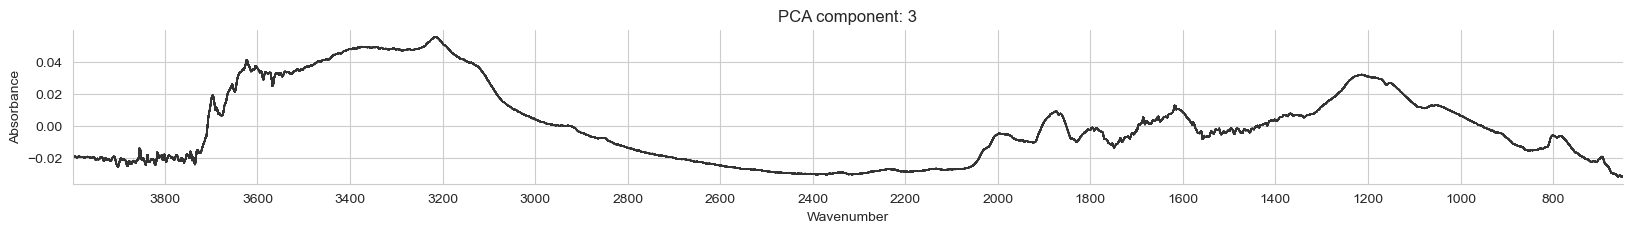

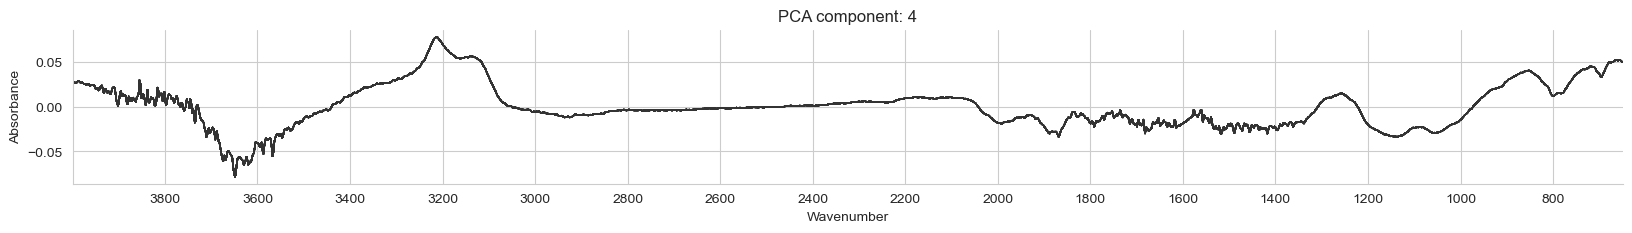

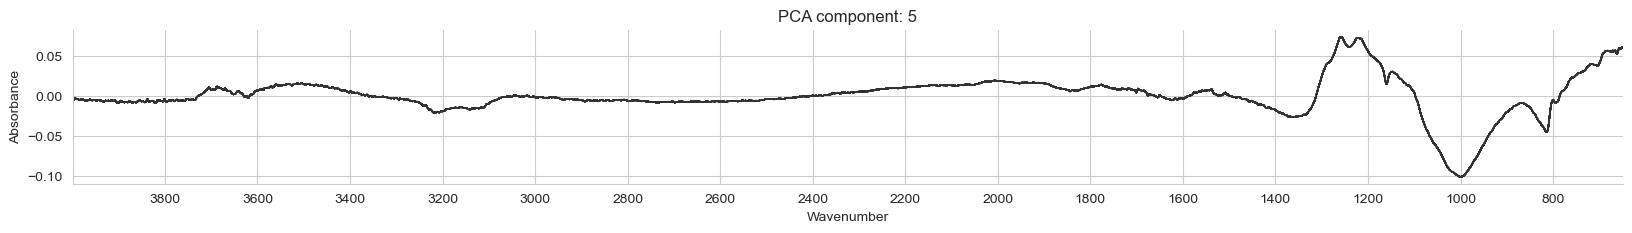

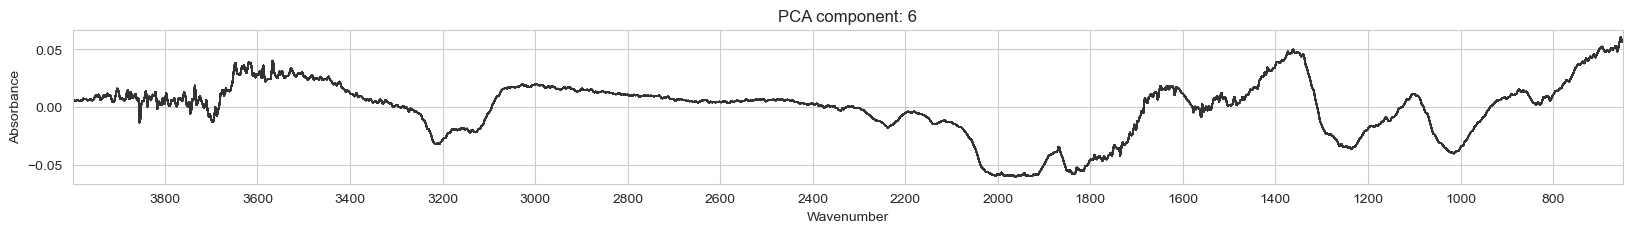

In [ ]:
for i in range(6):
    plot_spectra(pca.components_[i,:][None,:], wavenumbers, 
                 alpha=0.8, color='#333', 
                 title=f'PCA component: {i+ 1}',
                 ascending=ascending,
                 figsize=(20, 2))

In [ ]:
X_pca.shape

(134, 10)

In [ ]:
pca.inverse_transform(X_pca[,:2])

ValueError: shapes (134,2) and (10,1738) not aligned: 2 (dim 1) != 10 (dim 0)

In [ ]:
X_pca.argmax(axis=1)

array([2, 2, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 0, 3, 0, 2, 3, 3, 3, 3,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 3, 0, 2, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1,
       0, 0, 0, 5, 0, 0, 6, 0, 4, 5, 1, 0, 0, 1, 0, 0, 0, 5, 0, 0, 6, 0,
       4, 9, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1])

In [ ]:
names_selected

array(['LUI-0-0', 'LUI-0-1', 'LUI-0-2', 'LUI-0-3', 'LUI-0-4', 'LUI-1-0',
       'LUI-1-1', 'LUI-1-2', 'LUI-1-3', 'LUI-1-4', 'LUI-2-0', 'LUI-2-1',
       'LUI-2-2', 'LUI-2-3', 'LUI-2-4', 'LUI-3-0', 'LUI-3-1', 'LUI-3-2',
       'LUI-3-3', 'LUI-3-4'], dtype='<U9')

In [ ]:
label = [name.split('-')[1] for name in names_selected]

<Axes: >

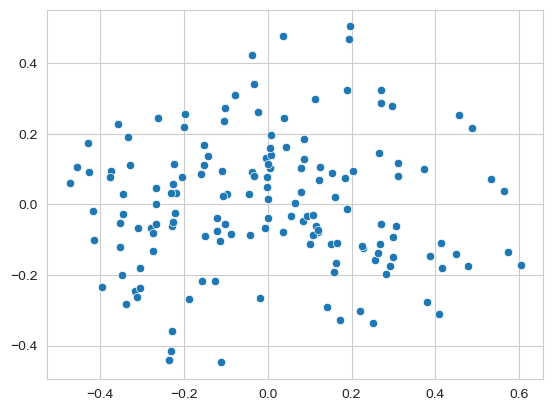

In [ ]:
cpt_x, cpt_y = 0, 1
# sns.scatterplot(x=X_pca[:,cpt_x], y=X_pca[:,cpt_y], hue=label)
sns.scatterplot(x=X_pca[:,cpt_x], y=X_pca[:,cpt_y])

## Kernel-PCA

In [ ]:
n_components = 20
kpca = KernelPCA(n_components=n_components, kernel='rbf')
X_kpca = kpca.fit_transform(X_t)

Text(0.5, 1.0, 'Kernel PCA Eigenvalues (RBF Kernel)')

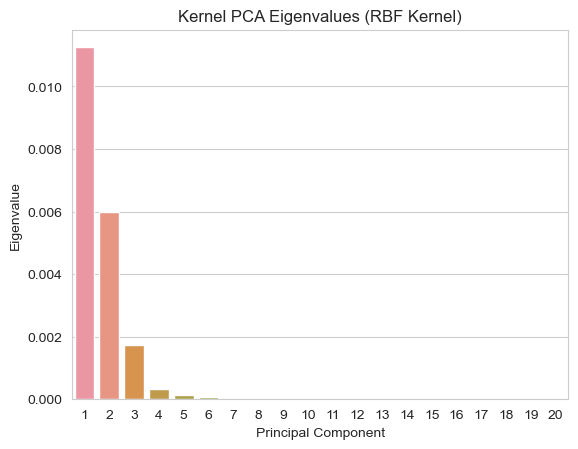

In [ ]:
# Create a range for the x-axis (one bar for each eigenvalue)
x_range = np.arange(1, len(kpca.eigenvalues_) + 1)

# Plot the eigenvalues using a bar plot
sns.barplot(x=x_range, y=kpca.eigenvalues_)

# Set the x-axis and y-axis labels and the plot title
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Kernel PCA Eigenvalues (RBF Kernel)')


<Axes: >

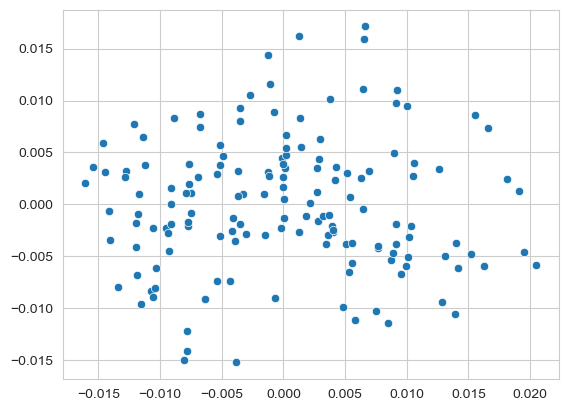

In [ ]:
cpt_x, cpt_y = 0, 1
sns.scatterplot(x=X_kpca[:,cpt_x], y=X_kpca[:,cpt_y])

## Wavelet

<matplotlib.collections.PathCollection>

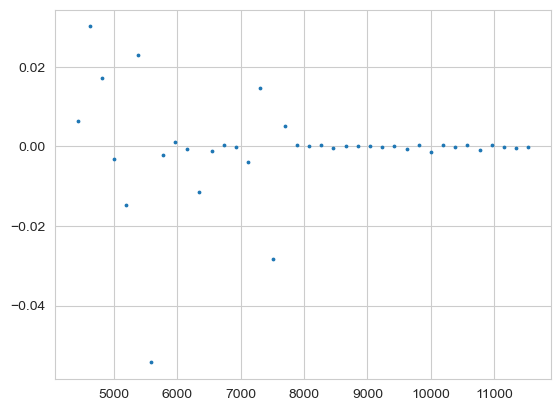

In [ ]:
idx = 2
coeffs = pywt.wavedec(spectrum, wavelet_name)
plt.scatter((wavenumbers[::len(wavenumbers)//len(coeffs[idx])])[:len(coeffs[idx])], coeffs[idx], s=3)

In [ ]:
len(wavenumbers)//23

41

In [ ]:
len(coeffs)

7

In [ ]:

approximation = coeffs[0]  # The first element of the list 'coeffs' is the approximation coefficients

# Detect peaks in the approximation coefficients
# This is a simplistic approach; you might need a more sophisticated peak detection algorithm
peaks, _ = find_peaks(approximation)

# Get peak heights from the original spectrum
# Map peak indices from approximation to original signal, if necessary
# This mapping would depend on the level of decomposition and the wavelet used
original_peaks = peaks * (len(spectrum) // len(approximation))
peak_heights.extend(spectrum[original_peaks])

# Convert list to numpy array
peak_heights = np.array(peak_heights)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(peak_heights, 'x', label='Peak Heights')
plt.xlabel('Sample Index')
plt.ylabel('Peak Height')
plt.title('Peak Heights Extracted from DWT')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


spectra = X[
# Assuming 'spectra' is your array of spectral data
# Each row in 'spectra' corresponds to a spectrum

# Choose a wavelet
wavelet_name = 'db5'  # Daubechies wavelet with 5 vanishing moments

# Initialize an array to store peak heights
peak_heights = []

# Perform DWT on each spectrum and detect peaks
for spectrum in spectra:
    # Apply DWT
    coeffs = pywt.wavedec(spectrum, wavelet_name)
    approximation = coeffs[0]  # The first element of the list 'coeffs' is the approximation coefficients

    # Detect peaks in the approximation coefficients
    # This is a simplistic approach; you might need a more sophisticated peak detection algorithm
    peaks, _ = find_peaks(approximation)
    
    # Get peak heights from the original spectrum
    # Map peak indices from approximation to original signal, if necessary
    # This mapping would depend on the level of decomposition and the wavelet used
    original_peaks = peaks * (len(spectrum) // len(approximation))
    peak_heights.extend(spectrum[original_peaks])

# Convert list to numpy array
peak_heights = np.array(peak_heights)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(peak_heights, 'x', label='Peak Heights')
plt.xlabel('Sample Index')
plt.ylabel('Peak Height')
plt.title('Peak Heights Extracted from DWT')
plt.legend()
plt.show()



AxisError: Axis greater than data dimensions